## Importation de librairies

In [2]:


import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Téléchargement du dataset FashionMNIST

In [3]:
from torchvision import datasets, transforms
batch_size = 128

# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='../../data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='../../data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


## 1. Definition de la classe CVAE


In [4]:


class ConvCVAE(nn.Module):
    def __init__(self, latent_dim=10, num_classes=10):
        super(ConvCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        
        # --- ENCODER ---
        # MODIFICATION 1 : Le premier Conv2d prend 1 + 10 = 11 canaux
        # (1 canal pour l'image N&B + 10 canaux pour les labels one-hot étirés)
        self.encoder = nn.Sequential(
            nn.Conv2d(1 + num_classes, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim) 
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim) 
        
        # --- DECODER ---
        # MODIFICATION 2 : L'entrée du décodeur prend Latent + Label
        self.fc_decode = nn.Linear(latent_dim + num_classes, 128 * 4 * 4) 
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x, c):
        # x: [Batch, 1, 28, 28]
        # c: [Batch, 10] (One-hot labels)
        
        # Astuce : On étire le vecteur label pour qu'il fasse la taille de l'image (28x28)
        # c devient [Batch, 10, 28, 28]
        c_expanded = c.view(-1, self.num_classes, 1, 1).expand(-1, -1, 28, 28)
        
        # On concatène sur la dimension des canaux (dim=1)
        # inputs devient [Batch, 11, 28, 28]
        inputs = torch.cat([x, c_expanded], 1)
        
        x = self.encoder(inputs)
        x = x.view(-1, 128 * 4 * 4)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, c):
        # z: [Batch, latent_dim]
        # c: [Batch, num_classes]
        
        # Ici c'est facile, ce sont deux vecteurs, on les colle
        inputs = torch.cat([z, c], 1) 
        
        x = self.fc_decode(inputs)
        x = x.view(-1, 128, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x, labels):
        # 1. Création du One-Hot Vector pour les labels
        c = torch.zeros(x.size(0), self.num_classes).to(x.device)
        c.scatter_(1, labels.view(-1, 1), 1)
        
        # 2. Encodage (Image + Condition)
        mu, logvar = self.encode(x, c)
        
        # 3. Sampling
        z = self.sample(mu, logvar)
        
        # 4. Décodage (Latent + Condition)
        recon_x = self.decode(z, c)
        
        return recon_x, mu, logvar

In [5]:
#fonction de perte
def loss_function(recon_x, x, mu, logvar, beta):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD,BCE, KLD

## 2. Entrainement du CVAE

In [6]:
# Hyperparameters
batch_size = 128
latent_dim = 2
learning_rate = 1e-3
epochs = 30
beta = 1

# Initialize the VAE model and the Adam optimizer
cvae =ConvCVAE(latent_dim=latent_dim, num_classes=10).to(device)
cvae.to(device)
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

# Listes pour stocker l'historique (pour le graphique plus tard)
history_loss = []
history_bce = []
history_kld = []

# Train the model for the given number of epochs
# At the end of each epoch, print the training loss 
# #a la difference du tp ici on rajoute les labels typiques du cvae

for epoch in range(1, epochs + 1):
    cvae.train()
    epoch_loss = 0
    bce_loss = 0
    kld_loss = 0
    running_loss = 0.0

    for batch_idx, (data, labels ) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae(data,labels)
        loss,bce,kld = loss_function(recon_batch, data, mu, logvar,beta)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()
        bce_loss += bce.item()
        kld_loss += kld.item()
    
    




## Visualisation des résultats

#### A. Visualisation de l'espace latent

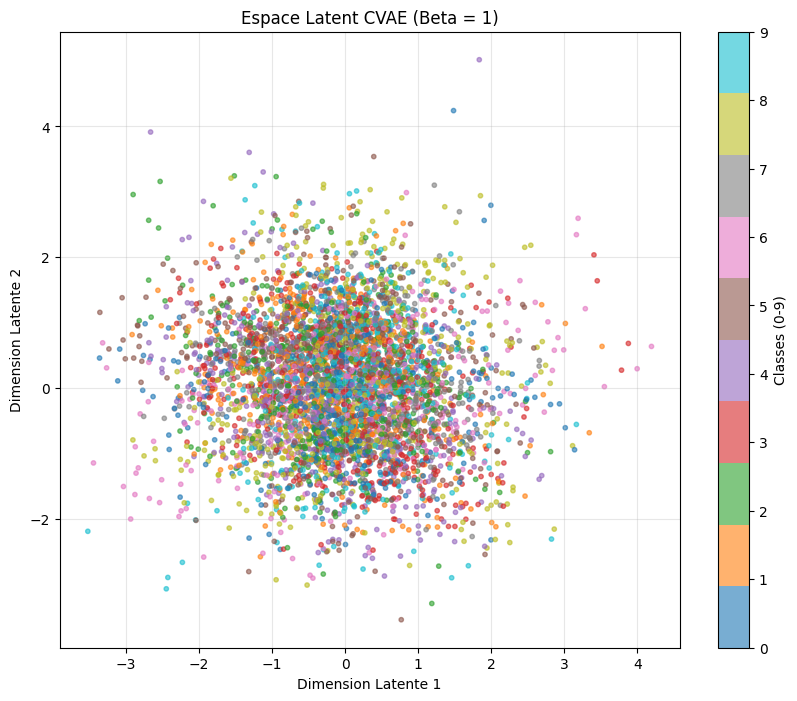

In [7]:
def plot_latent_space(model, beta):
    model.eval()
    with torch.no_grad():
        # On prend un grand lot d'images de test pour bien voir les clusters
        test_loader_viz = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=5000, shuffle=False)
        data, labels = next(iter(test_loader_viz))
        data, labels = data.to(device), labels.to(device)
        
        # --- C'EST ICI QUE CA CHANGE POUR LE CVAE ---
        # 1. Créer le vecteur One-Hot 'c' manuellement car model.encode() en a besoin
        c = torch.zeros(data.size(0), 10).to(device)
        c.scatter_(1, labels.view(-1, 1), 1)
        
        # 2. Encoder avec l'image ET la condition
        mu, logvar = model.encode(data, c)
        
        # 3. Récupérer les coordonnées (on utilise mu, la moyenne)
        z = mu.cpu().numpy()
        labels_np = labels.cpu().numpy()
        
        # 4. Affichage
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(z[:, 0], z[:, 1], c=labels_np, cmap='tab10', alpha=0.6, s=10)
        plt.colorbar(scatter, ticks=range(10), label='Classes (0-9)')
        plt.title(f'Espace Latent CVAE (Beta = {beta})')
        plt.xlabel('Dimension Latente 1')
        plt.ylabel('Dimension Latente 2')
        plt.grid(True, alpha=0.3)
        plt.show() #

plot_latent_space(cvae,beta)

c'est tout mélangé et c'est normal pour un cvae car on lui donne les étiquettes donc les vetements sont regroupés par style et non par classe.

#### B. Visulation des images décodées

In [8]:

def image_comparison(original_images, reconstructions, n_images=6):
    """Plots the original images and its reconstructions for comparison

    Args:
        original_image (torch.Tensor): The original images
        reconstructions (torch.Tensor): Reconstruction of the original images
    """
    fig, ax = plt.subplots(2, n_images, figsize=(20, 7))
    
    for i in range(n_images):
        # Plot original images
        ax[0, i].imshow(original_images[i], cmap='gray')
        ax[0, i].axis('off')
        ax[0, 0].set_title('Original')

        # Reconstructed images
        ax[1, i].imshow(reconstructions[i], cmap='gray')
        ax[1, i].axis('off')
        ax[1, 0].set_title('Recomstruction')
    
    plt.tight_layout()
    plt.show()

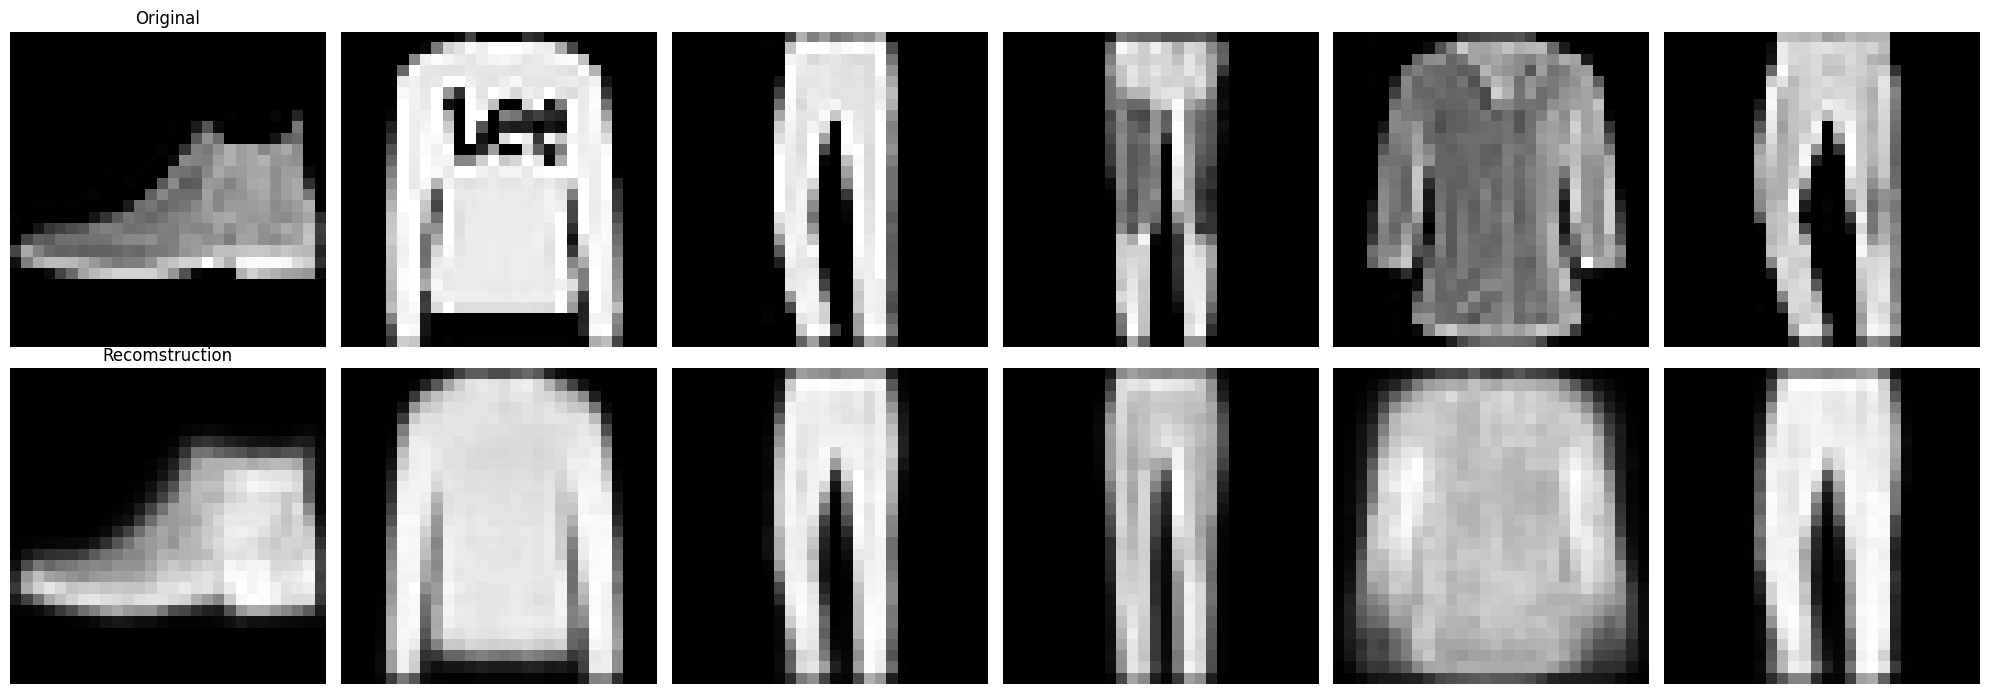

In [9]:
# Select a batch of images from the test dataset
# 'batch' contient le couple (images, labels)
batch = next(iter(test_loader)) 

# On sépare les images et les labels (Le CVAE a besoin des deux !)
inputs, labels = batch 

# Get the reconstructions of the selected images
# On passe inputs ET labels au modèle (et on met tout sur le device)
recons, _, _ = cvae(inputs.to(device), labels.to(device))

# Reshape the images for plotting
# Ici, je réutilise ton nom 'random_images' pour stocker les données numpy finales
random_images = inputs.cpu().numpy().squeeze()
recons = recons.detach().cpu().numpy().squeeze()

# Plot the original images and their reconstructions
# (On prend seulement les 6 premières pour que ça rentre dans ton affichage)
image_comparison(random_images[:6], recons[:6])

# Génération de 5 nouveaux échantillons (Question 3)

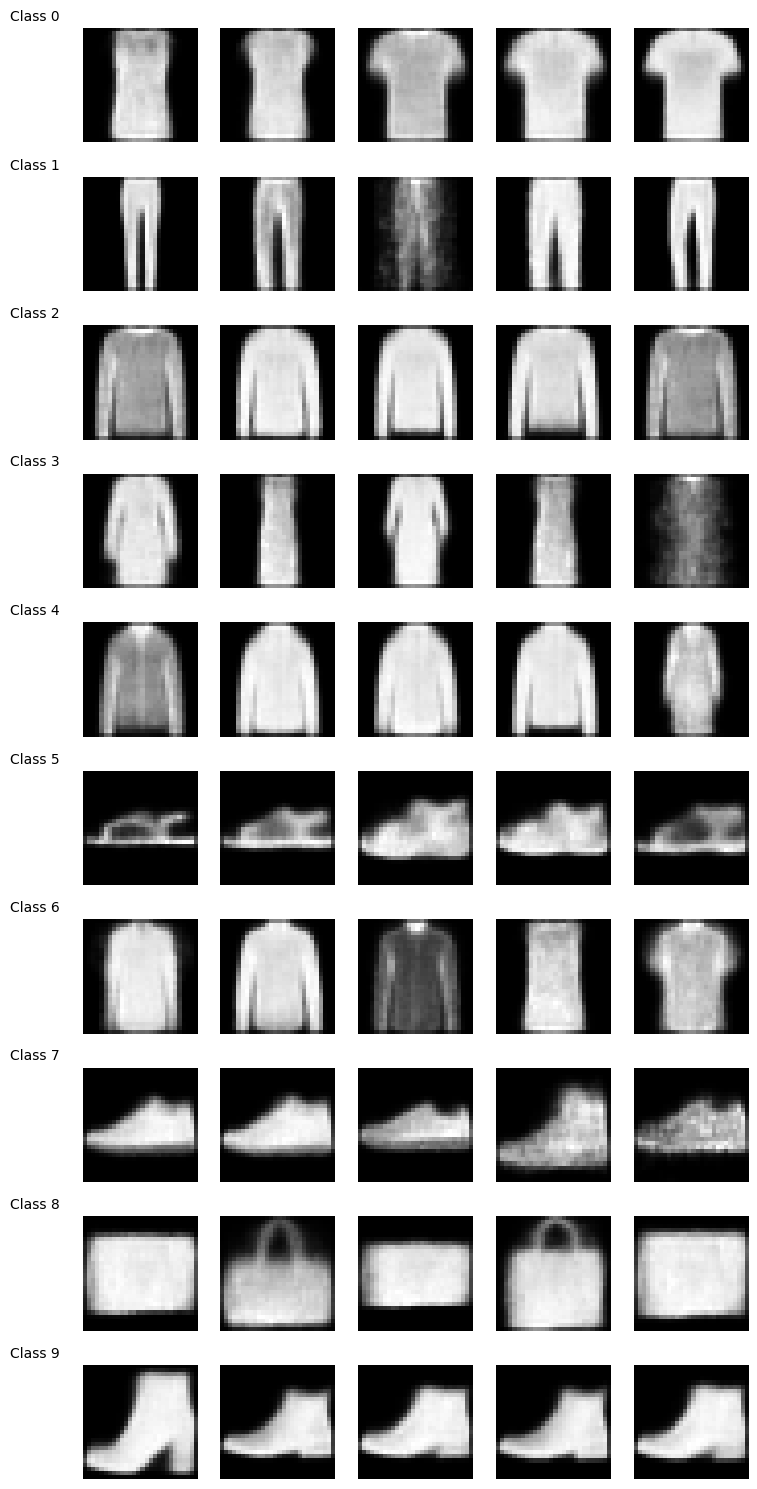

In [10]:
def generate_sample_per_class(num_samples=5):
    cvae.eval()
    num_classes = 10
    
    # On prépare une grille de plots : 10 lignes (classes), 5 colonnes (samples)
    fig, ax = plt.subplots(num_classes, num_samples, figsize=(num_samples * 1.5, num_classes * 1.5))
    
    with torch.no_grad():
        for class_idx in range(num_classes):
            # 1. Sample random latent vectors (z)
            # On génère 'num_samples' vecteurs de bruit
            z = torch.randn(num_samples, cvae.latent_dim).to(device) # z, le bruit, est aléatoire 
            
            # 2. Prepare the Condition (c)
            # On crée les labels pour la classe actuelle (ex: [0, 0, 0, 0, 0] pour la première boucle)
            labels = torch.tensor([class_idx] * num_samples).view(-1, 1).to(device) # on choisit la classe ( quel vetement on veut générer)
            
            # On convertit en One-Hot (nécessaire pour le décodeur du CVAE)
            c = torch.zeros(num_samples, num_classes).to(device)
            c.scatter_(1, labels, 1)
            
            # 3. Decode the latent vectors with the condition
            samples = cvae.decode(z, c)
            
            # Reshape pour l'affichage
            samples = samples.cpu().view(num_samples, 28, 28)

            # 4. Affichage dans la grille
            for i in range(num_samples):
                ax[class_idx, i].imshow(samples[i], cmap='gray')
                ax[class_idx, i].axis('off')
                
                # Ajout du titre seulement sur la première colonne
                if i == 0:
                    ax[class_idx, i].set_title(f"Class {class_idx}", fontsize=10, x=-0.2, ha='right')

    plt.tight_layout()
    plt.show()

# Lancer la génération
generate_sample_per_class(num_samples=5)

### tests des hyperparamètres 

In [11]:
import itertools

# 1. Définir les paramètres à tester
# Attention : ne mets pas trop de valeurs sinon ça prendra des heures !
param_grid = {
    'batch_size': [64, 128],
    'learning_rate': [1e-3, 1e-4],
    'beta': [1.0, 5.0],      # Le poids de la régularisation
    'latent_dim': [2, 10]    # Dimension de l'espace latent
}

# On crée toutes les combinaisons possibles
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"Nombre total de configurations à tester : {len(combinations)}")

# Variables pour sauvegarder le meilleur résultat
best_loss = float('inf')
best_params = {}
results = []

# Boucle principale de recherche
for i, params in enumerate(combinations):
    print(f"\n--- Test {i+1}/{len(combinations)} : {params} ---")
    
    # A. Configuration dynamique
    current_batch_size = params['batch_size']
    current_lr = params['learning_rate']
    current_beta = params['beta']
    current_latent = params['latent_dim']
    
    # Rechargement des DataLoaders avec la bonne batch_size
    train_loader = DataLoader(dataset=train_dataset, batch_size=current_batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=current_batch_size, shuffle=False)
    
    # B. Initialisation du modèle
    model = ConvCVAE(latent_dim=current_latent, num_classes=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=current_lr)
    
    # C. Entraînement court (ex: 5 epochs pour tester vite fait)
    # Tu peux augmenter si tu as du temps (ex: 10 ou 20)
    epochs_search = 5 
    
    for epoch in range(epochs_search):
        model.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(data, labels)
            loss, _, _ = loss_function(recon, data, mu, logvar, current_beta)
            loss.backward()
            optimizer.step()
            
    # D. Évaluation sur le Test Set (pour voir si c'est "le meilleur")
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            recon, mu, logvar = model(data, labels)
            loss, _, _ = loss_function(recon, data, mu, logvar, current_beta)
            test_loss += loss.item()
    
    avg_test_loss = test_loss / len(test_loader.dataset)
    print(f"--> Test Loss finale : {avg_test_loss:.4f}")
    
    # Sauvegarde des résultats
    results.append({'params': params, 'loss': avg_test_loss})
    
    # Est-ce le meilleur jusqu'à présent ?
    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        best_params = params
        # Optionnel : Sauvegarder le modèle complet si c'est le meilleur
        # torch.save(model.state_dict(), "best_cvae.pth")

print("\n================ RESULTATS FINAUX ================")
print(f"Meilleure Loss trouvée : {best_loss:.4f}")
print(f"Meilleurs paramètres : {best_params}")

# Afficher le top 3 des configurations
sorted_results = sorted(results, key=lambda x: x['loss'])
print("\nTop 3 Configurations :")
for res in sorted_results[:3]:
    print(res)

Nombre total de configurations à tester : 16

--- Test 1/16 : {'batch_size': 64, 'learning_rate': 0.001, 'beta': 1.0, 'latent_dim': 2} ---
--> Test Loss finale : 254.7504

--- Test 2/16 : {'batch_size': 64, 'learning_rate': 0.001, 'beta': 1.0, 'latent_dim': 10} ---
--> Test Loss finale : 239.1789

--- Test 3/16 : {'batch_size': 64, 'learning_rate': 0.001, 'beta': 5.0, 'latent_dim': 2} ---
--> Test Loss finale : 267.9099

--- Test 4/16 : {'batch_size': 64, 'learning_rate': 0.001, 'beta': 5.0, 'latent_dim': 10} ---
--> Test Loss finale : 265.5215

--- Test 5/16 : {'batch_size': 64, 'learning_rate': 0.0001, 'beta': 1.0, 'latent_dim': 2} ---
--> Test Loss finale : 255.7743

--- Test 6/16 : {'batch_size': 64, 'learning_rate': 0.0001, 'beta': 1.0, 'latent_dim': 10} ---
--> Test Loss finale : 242.9521

--- Test 7/16 : {'batch_size': 64, 'learning_rate': 0.0001, 'beta': 5.0, 'latent_dim': 2} ---
--> Test Loss finale : 268.7273

--- Test 8/16 : {'batch_size': 64, 'learning_rate': 0.0001, 'beta'

### test pour l'architecture

--- Lancement de la comparaison d'architecture ---
Paramètres (Modèle Normal): 254917
Paramètres (Modèle Petit): 73893
Entraînement architecture : Normal
Entraînement architecture : Petit


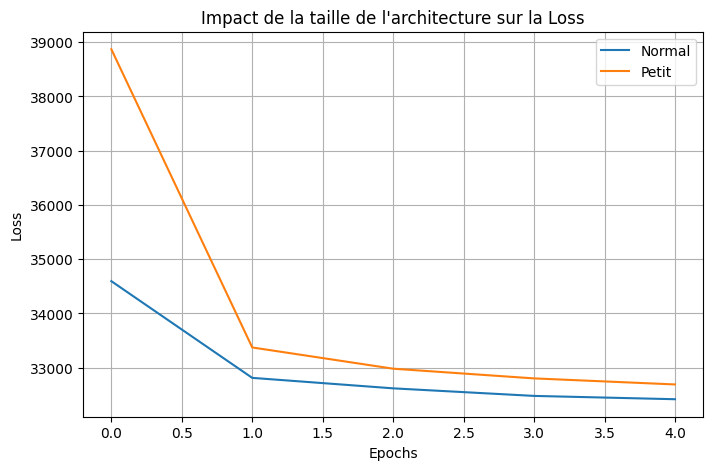

In [12]:
# Partie 1 : Choix de l'Architecture (CORRIGÉ)

class SmallConvCVAE(ConvCVAE):
    def __init__(self, latent_dim=10, num_classes=10):
        # On initialise la classe mère
        super(SmallConvCVAE, self).__init__(latent_dim, num_classes)
        
        # --- ENCODER PLUS PETIT ---
        # On réduit le nombre de filtres de moitié par rapport au modèle original
        self.encoder = nn.Sequential(
            nn.Conv2d(1 + num_classes, 16, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
        )

        # Les couches linéaires doivent correspondre à la sortie (64 * 4 * 4 = 1024)
        self.fc_mu = nn.Linear(64 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(64 * 4 * 4, latent_dim)
        
        # --- DECODER PLUS PETIT ---
        self.fc_decode = nn.Linear(latent_dim + num_classes, 64 * 4 * 4)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    # --- IL FAUT REDEFINIR ENCODE ET DECODE POUR UTILISER "64" ---
    def encode(self, x, c):
        c_expanded = c.view(-1, self.num_classes, 1, 1).expand(-1, -1, 28, 28)
        inputs = torch.cat([x, c_expanded], 1)
        
        x = self.encoder(inputs)
        
        # CORRECTION ICI : 64 au lieu de 128
        x = x.view(-1, 64 * 4 * 4) 
        
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def decode(self, z, c):
        inputs = torch.cat([z, c], 1) 
        x = self.fc_decode(inputs)
        
        # CORRECTION ICI : 64 au lieu de 128
        x = x.view(-1, 64, 4, 4)
        
        x = self.decoder(x)
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# --- Comparaison ---
print("--- Lancement de la comparaison d'architecture ---")
model_normal = ConvCVAE(latent_dim=2).to(device)
model_small = SmallConvCVAE(latent_dim=2).to(device)

print(f"Paramètres (Modèle Normal): {count_parameters(model_normal)}")
print(f"Paramètres (Modèle Petit): {count_parameters(model_small)}")

# Entraînement rapide de comparaison (5 epochs)
models = {'Normal': model_normal, 'Petit': model_small}
losses = {'Normal': [], 'Petit': []}

for name, model in models.items():
    print(f"Entraînement architecture : {name}")
    opt = optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    for epoch in range(5): # Tu peux réduire à 3 si c'est trop long
        epoch_loss = 0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            opt.zero_grad()
            recon, mu, logvar = model(data, labels)
            loss, _, _ = loss_function(recon, data, mu, logvar, beta=1)
            loss.backward()
            opt.step()
            epoch_loss += loss.item()
        losses[name].append(epoch_loss / len(train_loader))

# Plot
plt.figure(figsize=(8, 5))
for name, loss_curve in losses.items():
    plt.plot(loss_curve, label=name)
plt.title("Impact de la taille de l'architecture sur la Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### Test pour les hyperparamètres 

--- Comparaison des Learning Rates ---
Test avec LR = 0.01
Test avec LR = 0.001
Test avec LR = 0.0001


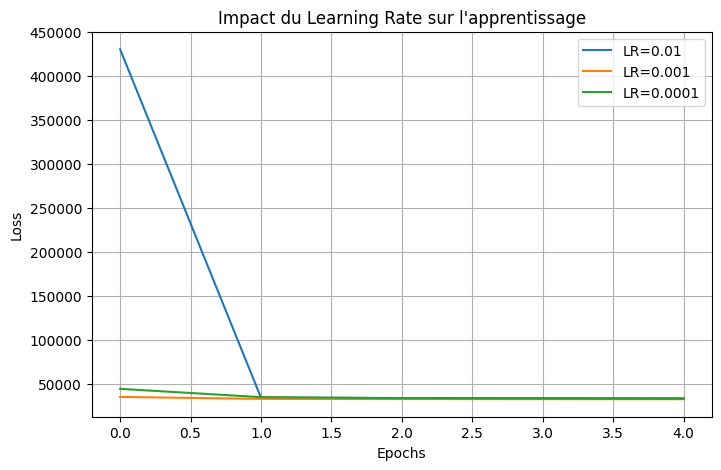

In [13]:
lrs_to_test = [1e-2, 1e-3, 1e-4]
loss_histories = {}

print("--- Comparaison des Learning Rates ---")

for lr in lrs_to_test:
    print(f"Test avec LR = {lr}")
    # Réinitialisation
    cvae_temp = ConvCVAE(latent_dim=2).to(device)
    opt_temp = optim.Adam(cvae_temp.parameters(), lr=lr)
    
    losses = []
    cvae_temp.train()
    
    # On fait juste 5 epochs pour voir la vitesse de convergence
    for epoch in range(5):
        batch_loss = 0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            opt_temp.zero_grad()
            recon, mu, logvar = cvae_temp(data, labels)
            loss, _, _ = loss_function(recon, data, mu, logvar, beta=1)
            loss.backward()
            opt_temp.step()
            batch_loss += loss.item()
        losses.append(batch_loss / len(train_loader))
    
    loss_histories[str(lr)] = losses

# Plot
plt.figure(figsize=(8, 5))
for lr, loss_curve in loss_histories.items():
    plt.plot(loss_curve, label=f"LR={lr}")
plt.title("Impact du Learning Rate sur l'apprentissage")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### choix de la fonction perte

--- Analyse des composantes de la Loss ---


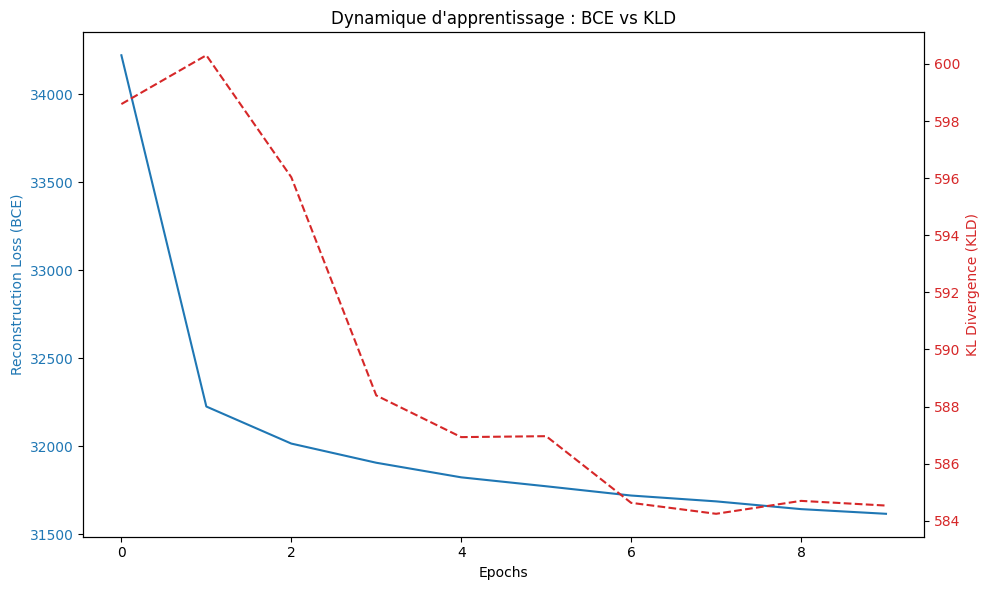

In [14]:
# On reprend ton modèle standard
final_model = ConvCVAE(latent_dim=2).to(device)
optimizer = optim.Adam(final_model.parameters(), lr=1e-3)

history_bce = []
history_kld = []
epochs_loss = 10 # Suffisant pour voir la dynamique

print("--- Analyse des composantes de la Loss ---")

for epoch in range(epochs_loss):
    final_model.train()
    epoch_bce = 0
    epoch_kld = 0
    
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = final_model(data, labels)
        
        # On récupère les composants séparés
        loss, bce, kld = loss_function(recon, data, mu, logvar, beta=1)
        
        loss.backward()
        optimizer.step()
        
        epoch_bce += bce.item()
        epoch_kld += kld.item()
        
    history_bce.append(epoch_bce / len(train_loader))
    history_kld.append(epoch_kld / len(train_loader))

# Plot avec deux échelles (car BCE est très grand et KLD très petit)
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Reconstruction Loss (BCE)', color=color)
ax1.plot(history_bce, color=color, label='BCE (Qualité Image)')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # Instancier un deuxième axe y
color = 'tab:red'
ax2.set_ylabel('KL Divergence (KLD)', color=color)
ax2.plot(history_kld, color=color, linestyle='--', label='KLD (Régularisation)')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Dynamique d'apprentissage : BCE vs KLD")
fig.tight_layout()
plt.show()